In [1]:
!pip install pyopencl pillow numpy matplotlib


In [2]:
%%writefile kernels.cl
// Gaussian kernel weights as macros for a 3x3 kernel
// These weights create a gentle blur effect (standard Gaussian blur)
#define K0 0.0625f  // Top-left
#define K1 0.125f   // Top-center
#define K2 0.0625f  // Top-right
#define K3 0.125f   // Middle-left
#define K4 0.25f    // Center
#define K5 0.125f   // Middle-right
#define K6 0.0625f  // Bottom-left
#define K7 0.125f   // Bottom-center
#define K8 0.0625f  // Bottom-right

// -------------------------------------
// Kernel 1: Gaussian Blur
// Applies a 3x3 Gaussian blur to an input image.
// Each work-item processes one pixel.
// -------------------------------------
__kernel void gaussian_blur(
    __global uchar4* input,   // Input image (RGBA, 8-bit per channel)
    __global uchar4* output,  // Output image (same format as input)
    int width,                // Image width
    int height                // Image height
) {
    // Get the x and y coordinates for this work-item (pixel)
    int x = get_global_id(0);
    int y = get_global_id(1);

    // Make sure we don't go out of bounds!
    if (x >= width || y >= height) return;

    // We'll accumulate the weighted sum of RGB channels here
    float3 sum = (float3)(0.0f, 0.0f, 0.0f);

    // Loop over the 3x3 neighborhood around the current pixel
    for (int dy = -1; dy <= 1; dy++) {
        for (int dx = -1; dx <= 1; dx++) {
            // Clamp coordinates to stay inside the image
            int sample_x = clamp(x + dx, 0, width - 1);
            int sample_y = clamp(y + dy, 0, height - 1);

            // Fetch the neighboring pixel
            uchar4 pixel = input[sample_y * width + sample_x];

            // Compute the index for the kernel weight (flattened 3x3)
            int kidx = (dy+1)*3 + (dx+1);

            // Select the correct Gaussian weight for this position
            float weight = 0.0f;
            switch(kidx) {
                case 0: weight = K0; break;
                case 1: weight = K1; break;
                case 2: weight = K2; break;
                case 3: weight = K3; break;
                case 4: weight = K4; break;
                case 5: weight = K5; break;
                case 6: weight = K6; break;
                case 7: weight = K7; break;
                case 8: weight = K8; break;
            }

            // Accumulate the weighted RGB values
            sum.x += weight * pixel.x;
            sum.y += weight * pixel.y;
            sum.z += weight * pixel.z;
        }
    }

    // Prepare the output pixel, clamp to [0,255] and preserve alpha
    uchar4 result;
    result.x = convert_uchar_sat(sum.x);
    result.y = convert_uchar_sat(sum.y);
    result.z = convert_uchar_sat(sum.z);
    result.w = input[y * width + x].w; // Keep original alpha channel
    output[y * width + x] = result;
}

// -------------------------------------
// Kernel 2: Logarithmic Tone Mapping
// Applies a simple logarithmic tone mapping to compress dynamic range.
// This is useful for displaying HDR images on standard displays.
// -------------------------------------
__kernel void tone_mapping(
    __global uchar4* input,   // Input image (RGBA, 8-bit per channel)
    __global uchar4* output,  // Output image (same format as input)
    int width,                // Image width
    int height,               // Image height
    float max_luminance       // Maximum luminance for normalization
) {
    // Get the x and y coordinates for this work-item (pixel)
    int x = get_global_id(0);
    int y = get_global_id(1);

    // Bounds check (always important!)
    if (x >= width || y >= height) return;

    // Fetch the input pixel and normalize RGB channels to [0,1]
    uchar4 pixel = input[y * width + x];
    float r = pixel.x / 255.0f;
    float g = pixel.y / 255.0f;
    float b = pixel.z / 255.0f;

    // Calculate luminance using standard Rec. 709 weights
    float Y = 0.2126f * r + 0.7152f * g + 0.0722f * b;
    float Y_out = 0.0f;

    // Apply logarithmic tone mapping (if luminance is non-zero)
    if (Y > 0.0f) {
        Y_out = log(1.0f + Y) / log(1.0f + max_luminance);
    }

    // Scale RGB channels to match the new luminance
    float scale = (Y > 1e-6f) ? (Y_out / Y) : 0.0f;
    float r_out = r * scale;
    float g_out = g * scale;
    float b_out = b * scale;

    // Write the result, converting back to [0,255] and preserving alpha
    uchar4 result;
    result.x = convert_uchar_sat(r_out * 255.0f);
    result.y = convert_uchar_sat(g_out * 255.0f);
    result.z = convert_uchar_sat(b_out * 255.0f);
    result.w = pixel.w;  // Preserve alpha channel

    output[y * width + x] = result;
}


Overwriting kernels.cl


In [11]:
import numpy as np
import pyopencl as cl
from PIL import Image
import matplotlib.pyplot as plt

def process_image(image_path, max_luminance=1.0):
    # Load the image from disk and convert it to RGBA format (ensures 4 channels)
    img = Image.open(image_path).convert("RGBA")
    img_np = np.asarray(img).astype(np.uint8)  # Convert to NumPy array (uint8)
    height, width, _ = img_np.shape  # Get image dimensions
    
    # Flatten the image to a 1D uchar4 array (OpenCL expects this format)
    img_flat = img_np.view(dtype=np.uint8).reshape(height * width, 4)
    
    # -------------------------------
    # Initialize OpenCL environment
    # -------------------------------
    platform = cl.get_platforms()[0]  # Select the first available platform
    device = platform.get_devices(device_type=cl.device_type.GPU)[0]  # Use the first GPU device
    ctx = cl.Context([device])  # Create OpenCL context
    queue = cl.CommandQueue(ctx)  # Create command queue for the device
    
    # -------------------------------
    # Create OpenCL buffers
    # -------------------------------
    mf = cl.mem_flags  # Memory flags for buffer creation
    input_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=img_flat)  # Input image buffer
    temp_buf = cl.Buffer(ctx, mf.READ_WRITE, size=img_flat.nbytes)  # Temporary buffer for intermediate results
    output_buf = cl.Buffer(ctx, mf.WRITE_ONLY, size=img_flat.nbytes)  # Output buffer for final image
    
    # -------------------------------
    # Load and compile OpenCL kernels
    # -------------------------------
    with open("kernels.cl", "r") as f:
        kernel_code = f.read()
    program = cl.Program(ctx, kernel_code).build()  # Build the kernels
    
    # Get references to the kernel functions
    gaussian_kernel = program.gaussian_blur
    tone_mapping_kernel = program.tone_mapping
    
    # -------------------------------
    # Set kernel arguments
    # -------------------------------
    gaussian_kernel.set_args(input_buf, temp_buf, np.int32(width), np.int32(height))
    tone_mapping_kernel.set_args(temp_buf, output_buf, np.int32(width), np.int32(height), np.float32(max_luminance))
    
    # Define the global size (work-items) for both kernels (one per pixel)
    global_size = (width, height)
    
    # -------------------------------
    # Execute the kernels
    # -------------------------------
    # Stage 1: Apply Gaussian blur (results go to temp_buf)
    event1 = cl.enqueue_nd_range_kernel(queue, gaussian_kernel, global_size, None)
    event1.wait()  # Wait for Gaussian blur to finish before proceeding
    
    # Stage 2: Apply tone mapping (results go to output_buf)
    event2 = cl.enqueue_nd_range_kernel(queue, tone_mapping_kernel, global_size, None)
    event2.wait()  # Wait for tone mapping to finish before reading results
    
    # -------------------------------
    # Retrieve results from the GPU
    # -------------------------------
    result_flat = np.empty_like(img_flat)  # Prepare an empty array for results
    cl.enqueue_copy(queue, result_flat, output_buf).wait()  # Copy data from device to host
    
    # Reshape the flat result back to (height, width, 4) image format and return
    return result_flat.view(dtype=np.uint8).reshape(height, width, 4)


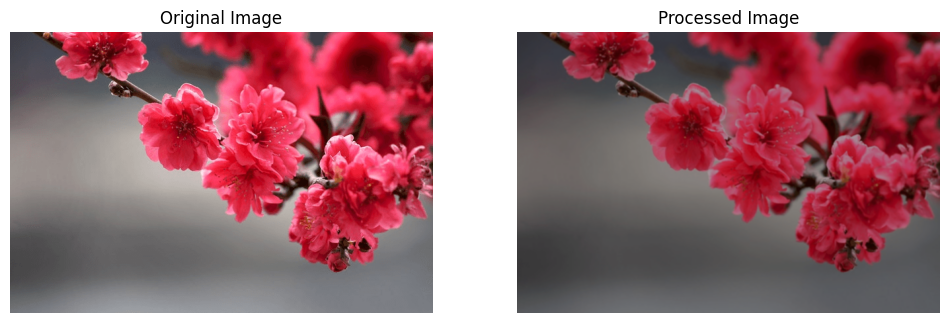

In [13]:
# ------------------------------------
# Process the input image using OpenCL
# ------------------------------------
input_path = "img.png"  # <-- Make sure to upload your image file with this name!
output_image = process_image(input_path, max_luminance=2.0)  # You can vary max_luminance for different effects

# ------------------------------------
# Display the original and processed images side by side
# ------------------------------------
plt.figure(figsize=(12, 6))  # Create a wide figure for side-by-side comparison

# Show the original image on the left
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(Image.open(input_path))
plt.axis('off')  # Hide axis ticks for a cleaner look

# Show the processed image on the right
plt.subplot(1, 2, 2)
plt.title("Processed Image")
plt.imshow(output_image)
plt.axis('off')  # Hide axis ticks

plt.show()  # Display the figure

# ------------------------------------
# Save the processed image to disk
# ------------------------------------
Image.fromarray(output_image, 'RGBA').save("output.png")  # Output is saved as 'output.png'
